In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pyosrd import OSRD
small_infra = OSRD('../cases/small_infra/')

In [3]:
small_infra = OSRD('../cases/small_infra/')

In [4]:
small_infra.run()

[13:56:18,506] [INFO]  [StandaloneSimulationCommand] Loading infra: ../cases/small_infra/infra.json
[13:56:18,552] [INFO]              [FullInfra] parsing infra
[13:56:18,645] [INFO]              [FullInfra] adaptation to kotlin
[13:56:18,701] [INFO]              [FullInfra] loading signals
[13:56:18,710] [INFO]              [FullInfra] building blocks
[13:56:18,720] [INFO]  [StandaloneSimulationCommand] Loading input: ../cases/small_infra/simulation.json
[13:56:18,740] [INFO]  [StandaloneSimulationCommand] Running simulation for schedule group: group.0
[13:56:18,818] [DEBUG]             [Allowance] computing range n°1
[13:56:18,821] [DEBUG]             [Allowance]   computing section n°1
[13:56:18,821] [DEBUG]             [Allowance]   target time = 353.40375
[13:56:18,821] [DEBUG]             [Allowance]     starting attempt 1
[13:56:18,823] [DEBUG]             [Allowance]     envelope time 596.245
[13:56:18,823] [DEBUG]             [Allowance]     starting attempt 2
[13:56:18,823] [

In [5]:
from pyosrd.viz.map import folium_map

(600.0, 682.4868333236357)

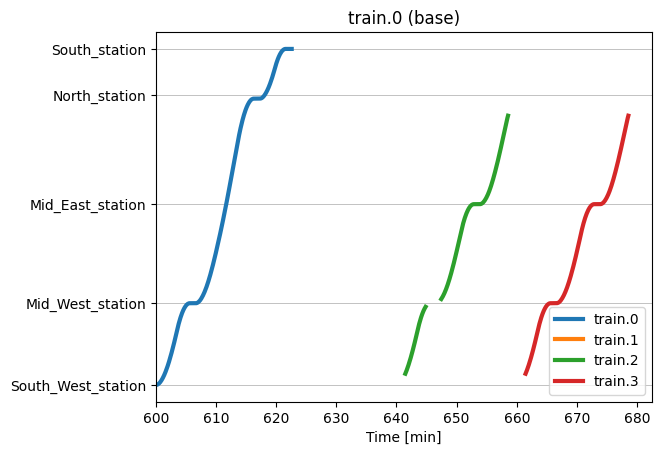

In [6]:
ax = small_infra.space_time_chart(
    0,
    points_to_show=['station',],
    eco_or_base='base',
)
ax.set_xlim(left=min(small_infra.departure_times)/60.)


In [7]:
self=small_infra
train=2

In [8]:
import numpy as np
from pyosrd.osrd import Point
import pandas as pd
import folium
from haversine import haversine

In [9]:
additional_records = []

times = [record['time'] for record in self._head_position(train)]
offsets = [
    self.offset_in_path_of_train(
        Point(
            track_section=record['track_section'],
            position=record['path_offset']
        ),
        train
    )
    for record in self._head_position(train)
]

for track in small_infra.train_track_sections(train):

    track_section = [t for t in small_infra.infra['track_sections'] if t['id']==track['id']][0]
    path_offset_begin = small_infra.offset_in_path_of_train(
            Point(track_section=track_section['id'], position=0), train
        )
    path_offset_end = small_infra.offset_in_path_of_train(
            Point(track_section=track_section['id'], position=track_section['length']),
            train=train,
        )
    additional_records+=([{
        'track_section': track_section['id'],
        'offset': 0,
        'path_offset': path_offset_begin,
        'time': np.interp(path_offset_begin, offsets, times).item()
    },  {
        'track_section': track_section['id'],
        'offset':track_section['length'],
        'path_offset': path_offset_end,
        'time': np.interp(path_offset_end, offsets, times).item()
    }])

In [10]:
additional_records = []

In [11]:
track_section_coordinates = {
    ts['id']: [(point[1], point[0]) for point in ts['geo']['coordinates']]
    for ts in self.infra['track_sections']
}

track_section_geo_lengths = {
    ts['id']: haversine(
        (
            ts['geo']['coordinates'][0][1],
            ts['geo']['coordinates'][0][0]
        ),
        (
            ts['geo']['coordinates'][-1][1],
            ts['geo']['coordinates'][-1][0]
        ),
        unit='m'
    )
    for ts in self.infra['track_sections']
    }

def coords_from_position_on_track(
    track_section: str,
    position: float,
) -> list[float]:
    length = self.track_section_lengths[track_section]
    pos = position / length
    positions = [
        haversine(
            point, track_section_coordinates[track_section][0], unit='m'
        )
        / track_section_geo_lengths[track_section]
        for point in track_section_coordinates[track_section]
    ]
    lats = [coord[0] for coord in track_section_coordinates[track_section]]
    lngs = [coord[1] for coord in track_section_coordinates[track_section]]
    return [
        np.interp([pos], positions, lats).item(),
        np.interp([pos], positions, lngs).item(),
    ]

records = [r for r in self._head_position(train) + additional_records if r['path_offset'] is not None]
records.sort(key=lambda x: x['path_offset'])
for r in records:
    r['lat'], r['long'] = coords_from_position_on_track(r['track_section'], r['offset'])
    
lats = [r['lat'] for r in records]
longs = [r['long'] for r in records]
times = [r['time'] for r in records]
times_ = np.arange(start=records[0]['time'], stop=max(times), step=5)
coords_ = list(zip(np.interp(times_, times, longs), np.interp(times_, times, lats)))

In [12]:
m = folium_map(small_infra)
folium.plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": [
            {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": coords_, #[[r['long'], r['lat']] for r in records],
                },
                "properties": {
                    'times': [str(pd.to_datetime('today').normalize() + pd.DateOffset(seconds=t)) for t in times_],
                    "tooltip": "train_0",
                },
            },
            {
                "type": "Feature",
                "geometry": {
                    "type": "MultiPoint",
                    "coordinates": coords_, #[[r['long'], r['lat']] for r in records],
                },
                "properties": {
                    'times': [str(pd.to_datetime('today').normalize() + pd.DateOffset(seconds=t+3*60.)) for t in times_],
                    "tooltip": "train_plus_3",
                    "icon": "circle",
                    "iconstyle": {
                        "fillColor": "green",
                        "fillOpacity": 1,
                        "stroke": "false",
                        # "radius": 13,
                    },
                    "style": {"weight": 0}, 
                },
            },
        ],
    },
    loop=False,
    duration='PT5S',
    period='PT5S',
).add_to(m)

In [13]:
m